In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from sklearn import metrics

In [ ]:
stock = pd.read_csv("/content/drive/My Drive/ELEN6889/Stock_price_five_year/AMZN.csv")
stock.columns = ['date','close_value']
stock

,date,close_value
0,2015-01-01,310.35
1,2015-01-02,308.52
2,2015-01-03,308.52
3,2015-01-04,308.52
4,2015-01-05,302.19
...,...,...
1821,2019-12-27,1869.80
1822,2019-12-28,1869.80
1823,2019-12-29,1869.80
1824,2019-12-30,1846.89


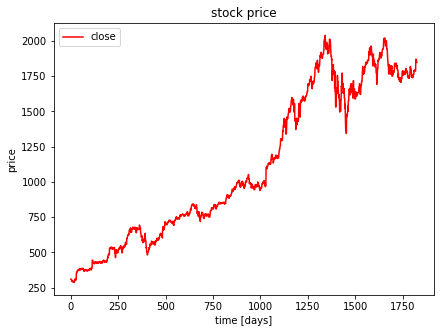

In [ ]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(stock.close_value, color='red', label='close')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
plt.show()



In [ ]:
tweet = pd.read_csv("/content/drive/My Drive/ELEN6889/tweet_five_years_scores/Amazon_date_scores/AMZN-score.csv")
tweet['date'] = pd.to_datetime(tweet.date)
tweet['date'] = tweet['date'].dt.strftime('%Y-%m-%d')
tweet.sort_values("date",inplace=True)
tweet

,date,mean,count,normalized
1722,2015-01-01,0.488550,131,0.484834
490,2015-01-02,0.760684,117,0.754210
334,2015-01-03,0.855263,76,0.844083
224,2015-01-04,0.770677,266,0.767785
353,2015-01-05,0.632812,256,0.630345
...,...,...,...,...
1248,2019-12-27,0.693277,952,0.692549
321,2019-12-28,0.663102,187,0.659565
1559,2019-12-29,0.710526,152,0.705867
1526,2019-12-30,0.674952,523,0.673663


In [ ]:
data = pd.merge(stock,tweet,on='date')
data.index = data['date']
data

,date,close_value,mean,count,normalized
date,,,,,
2015-01-01,2015-01-01,310.35,0.488550,131,0.484834
2015-01-02,2015-01-02,308.52,0.760684,117,0.754210
2015-01-03,2015-01-03,308.52,0.855263,76,0.844083
2015-01-04,2015-01-04,308.52,0.770677,266,0.767785
2015-01-05,2015-01-05,302.19,0.632812,256,0.630345
...,...,...,...,...,...
2019-12-27,2019-12-27,1869.80,0.693277,952,0.692549
2019-12-28,2019-12-28,1869.80,0.663102,187,0.659565
2019-12-29,2019-12-29,1869.80,0.710526,152,0.705867


In [ ]:
data1 = data[['close_value','mean','count']]
data1.head()

,close_value,mean,count
date,,,
2015-01-01,310.35,0.488550,131
2015-01-02,308.52,0.760684,117
2015-01-03,308.52,0.855263,76
2015-01-04,308.52,0.770677,266
2015-01-05,302.19,0.632812,256


In [ ]:
# pct change based on Adj close value
data1["pct_change"] = data1["close_value"].pct_change()

# Drop null values
data1.dropna(inplace = True)
data1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,close_value,mean,count,pct_change
date,,,,
2015-01-02,308.52,0.760684,117,-0.005897
2015-01-03,308.52,0.855263,76,0.000000
2015-01-04,308.52,0.770677,266,0.000000
2015-01-05,302.19,0.632812,256,-0.020517
2015-01-06,295.29,0.706044,364,-0.022833
...,...,...,...,...
2019-12-27,1869.80,0.693277,952,0.000551
2019-12-28,1869.80,0.663102,187,0.000000
2019-12-29,1869.80,0.710526,152,0.000000


In [ ]:
# This function "window_data" accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number):
    # Create empty lists "X_close", "X_polarity", "X_volume" and y
    X_close = []
    X_polarity = []
    X_volume = []
    y = []
    for i in range(len(df) - window):
        
        # Get close, ts_polarity, tw_vol, and target in the loop
        close = df.iloc[i:(i + window), feature_col_number1]
        ts_polarity = df.iloc[i:(i + window), feature_col_number2]
        tw_vol = df.iloc[i:(i + window), feature_col_number3]
        target = df.iloc[(i + window), target_col_number]
        
        # Append values in the lists
        X_close.append(close)
        X_polarity.append(ts_polarity)
        X_volume.append(tw_vol)
        y.append(target)
        
    return np.hstack((X_close,X_polarity,X_volume)), np.array(y).reshape(-1, 1)

In [ ]:
# Predict Closing Prices using a 3 day window of previous closing prices
window_size = 3

feature_col_number1 = 0 #the close_value` column
feature_col_number2 = 1 #the twitter mean score column
feature_col_number3 = 2 #the twitter count column
target_col_number = 0
X, y = window_data(data1, window_size, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)

In [ ]:
# Use 70% of the data for training and the remaineder for testing
X_split = int(0.7 * len(X))
y_split = int(0.7 * len(y))

X_train = X[: X_split]
X_test = X[X_split:]
y_train = y[: y_split]
y_test = y[y_split:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Use the MinMaxScaler to scale data between 0 and 1.
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [ ]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Build the LSTM model. 

# Define the LSTM RNN model.
model = Sequential()

number_units = 9
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
    
model.add(Dropout(dropout_fraction))

# Layer 2
# The return_sequences parameter needs to set to True every time we add a new LSTM layer, excluding the final layer.
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [ ]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 9, 9)              396       
                                                                 
 dropout (Dropout)           (None, 9, 9)              0         
                                                                 
 lstm_1 (LSTM)               (None, 9, 9)              684       
                                                                 
 dropout_1 (Dropout)         (None, 9, 9)              0         
                                                                 
 lstm_2 (LSTM)               (None, 9)                 684       
                                                                 
 dropout_2 (Dropout)         (None, 9)                 0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=5, verbose=1)

Epoch 1/10
255/255 [==============================] - 8s 10ms/step - loss: 0.0063
Epoch 2/10
255/255 [==============================] - 3s 11ms/step - loss: 0.0295
Epoch 3/10
255/255 [==============================] - 3s 10ms/step - loss: 0.0263
Epoch 4/10
255/255 [==============================] - 3s 11ms/step - loss: 0.0191
Epoch 5/10
255/255 [==============================] - 2s 9ms/step - loss: 0.0136
Epoch 6/10
255/255 [==============================] - 3s 10ms/step - loss: 0.0078
Epoch 7/10
255/255 [==============================] - 3s 11ms/step - loss: 0.0059
Epoch 8/10
255/255 [==============================] - 3s 11ms/step - loss: 0.0057
Epoch 9/10
255/255 [==============================] - 3s 11ms/step - loss: 0.0057
Epoch 10/10
255/255 [==============================] - 2s 9ms/step - loss: 0.0053


In [ ]:
# Evaluate the model for loss
model.evaluate(X_test, y_test)

18/18 [==============================] - 1s 4ms/step - loss: 0.0097


0.009692433290183544

In [ ]:
# Make some predictions
predicted = model.predict(X_test)

In [ ]:
# Evaluating the model
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

Root Mean Squared Error: 0.09845016017836838
R-squared : 0.7099937170039243


In [ ]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = data1.index[-len(real_prices): ]) 
stocks

,Real,Predicted
date,,
2018-07-03,1693.96,1787.532104
2018-07-04,1693.96,1749.856689
2018-07-05,1699.73,1759.613281
2018-07-06,1710.63,1766.901245
2018-07-07,1710.63,1767.748291
...,...,...
2019-12-27,1869.80,1888.200073
2019-12-28,1869.80,1920.687988
2019-12-29,1869.80,1958.718994


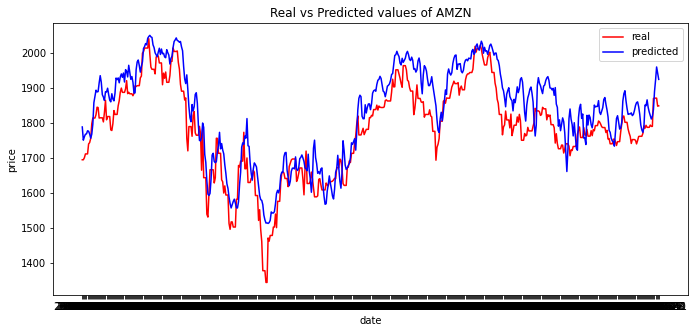

In [41]:
plt.figure(figsize=(25, 5));
plt.subplot(1,2,1);
plt.plot(stocks.Real, color='red', label='real')
plt.plot(stocks.Predicted, color='blue', label='predicted')
plt.title('Real vs Predicted values of AMZN')
plt.xlabel('date')
plt.ylabel('price')
plt.legend(loc='best')
plt.show()